In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [2]:
# data = pd.read_csv(
# 	'https://raw.githubusercontent.com/numenta'
# 	'/NAB/master/data/realKnownCause/ambient'
# 	'_temperature_system_failure.csv')

data = pd.read_csv("ec2_cpu_utilization_5f5533.csv")
# Exclude datetime column
# data_values = data.drop('timestamp',
# 						axis=1).values

# # Convert data to float type
# data_values = data_values.astype('float32')

# # Create new dataframe with converted values
# data_converted = pd.DataFrame(data_values,
# 							columns=data.columns[1:])

# # Add back datetime column
# data_converted.insert(0, 'timestamp',
# 					data['timestamp'])
data_converted = data.copy().dropna()


<Axes: title={'center': 'Ambient Temperature Over Time'}, xlabel='timestamp'>

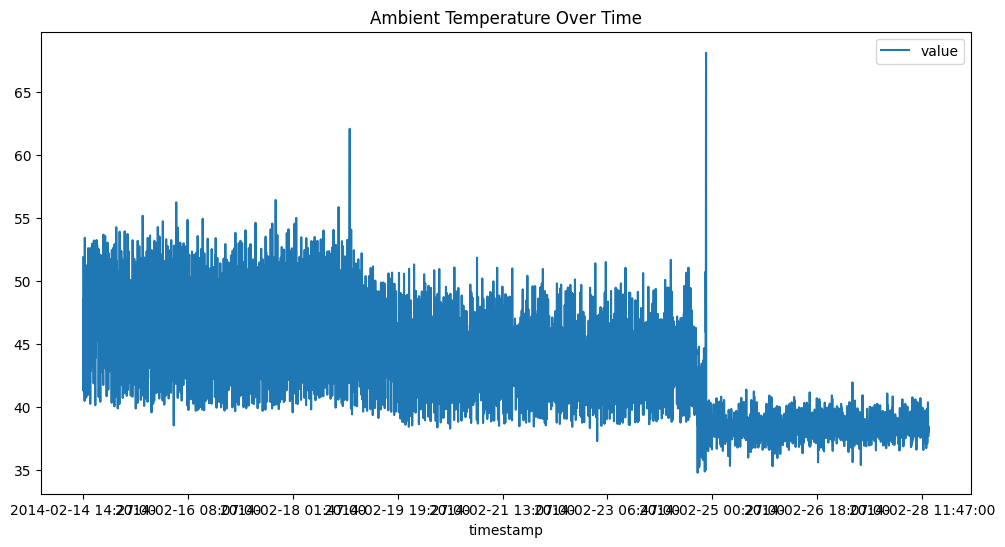

In [3]:
data_converted.plot(x='timestamp',y='value',title='Ambient Temperature Over Time',figsize=(12, 6))    

In [4]:
# Exclude datetime column again
data_tensor = tf.convert_to_tensor(data_converted.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim = data_converted.shape[1] - 1
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and fit the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=150,
				batch_size=32, shuffle=True, verbose=0)

# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
					axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


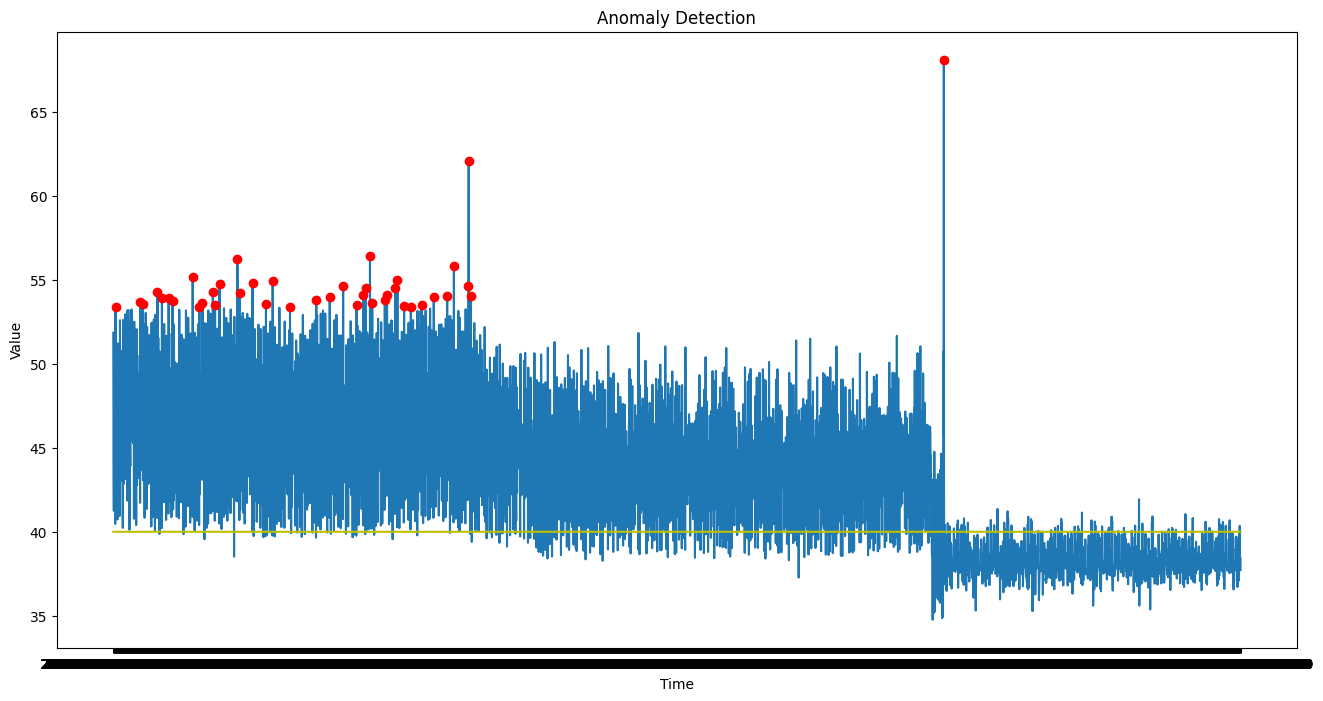

In [6]:
threshold = anomaly_scores.quantile(0.99)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
# Plot the data with anomalies marked in red
plt.figure(figsize=(16, 8))
plt.plot(data_converted['timestamp'],
		data_converted['value']),
plt.plot(data_converted['timestamp'],
		reconstructions.ravel()+40, 'y')
plt.plot(data_converted['timestamp'][anomalous],
		data_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

## Let's try to solve using Prophet

In [ ]:
# %pip install prophet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
from prophet import Prophet
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')

In [16]:
def run_prophet_anomaly_detection(df, metric_name, cpr=0.5):
    # Prepare DataFrame for Prophet
    prophet_df = df.rename(columns={'timestamp': 'ds', metric_name: 'y'})

    # Ensure the 'y' column is numeric, coercing errors
    prophet_df['y'] = pd.to_numeric(prophet_df['y'], errors='coerce')
    # Drop rows where 'y' became NaN due to coercion
    prophet_df.dropna(subset=['y'], inplace=True)

    if prophet_df.empty:
        print(f"--- Anomaly Detection for: {metric_name.upper()} ---")
        print(f"Error: After preparing data, the DataFrame for '{metric_name}' is empty or contains no valid numeric data.")
        return None, None, None, None # Return None for all expected outputs

    # Initialize Prophet model
    m = Prophet(
        growth='linear',
        changepoint_range=cpr,
        seasonality_mode='additive',
        yearly_seasonality=False, # We don't have enough data for yearly
        weekly_seasonality=True,  # Default, but good to be explicit
        daily_seasonality=True# Default, but good to be explicit
    )

    # Adding hourly seasonality as requested
    # The fourier_order parameter controls how complex the seasonality model is
    # m.add_seasonality(name='hourly', period=1/24, fourier_order=5)
    # m.add_seasonality(name='quarter_hourly', period=1/96, fourier_order=5)
    m.add_seasonality(name='five_minute', period=1/288, fourier_order=15)

    try:
        # Fit the model
        m.fit(prophet_df)
    except Exception as e:
        print(f"--- Anomaly Detection for: {metric_name.upper()} ---")
        print(f"Error during Prophet model fitting: {e}")
        return None, None, None, None # Return None for all expected outputs


    # Make future predictions
    future = m.make_future_dataframe(periods=0, freq='5S')
    forecast = m.predict(future)

    # Merge original data with forecast to find anomalies
    forecast_with_data = pd.merge(prophet_df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

    # Identify anomalies with 
    margin = 0.15

    forecast_with_data['anomaly'] = forecast_with_data.apply(
        lambda row: 1 if row['y'] > row['yhat_upper']*(1+margin) or row['y'] < row['yhat_lower']*(1-margin) else 0, axis=1
    )

    anomalies = forecast_with_data[forecast_with_data['anomaly'] == 1]

    print(f"--- Anomaly Detection for: {metric_name.upper()} ---")
    print(f"Number of anomalies found: {len(anomalies)}")
    if not anomalies.empty:
        print("\nAnomalous data points:")
        print(anomalies[['ds', 'y', 'yhat_lower', 'yhat_upper']])

    return m, forecast_with_data, anomalies, forecast

In [17]:
def plot_metric(forecast_df, anomalies, metric_name):
  fig = go.Figure()

  # Plot the forecast confidence interval
  fig.add_trace(go.Scatter(
      x=forecast_df['ds'],
      y=forecast_df['yhat_upper'],
      mode='lines',
      line=dict(color='rgba(0,0,0,0)'),
      name='Upper Bound',
      showlegend=False
  ))
  fig.add_trace(go.Scatter(
      x=forecast_df['ds'],
      y=forecast_df['yhat_lower'],
      mode='lines',
      line=dict(color='rgba(0,0,0,0)'),
      fill='tonexty',
      fillcolor='rgba(128,128,128,0.2)',
      name='Forecast Interval'
  ))

  # Plot the actual metric data
  fig.add_trace(go.Scatter(
      x=forecast_df['ds'],
      y=forecast_df['y'],
      mode='lines+markers',
      name=f'{metric_name} Usage',
      line=dict(color='blue')
  ))

  # Plot the detected anomalies
  fig.add_trace(go.Scatter(
      x=anomalies['ds'],
      y=anomalies['y'],
      mode='markers',
      name='Anomaly',
      marker=dict(color='red', size=10, symbol='x')
  ))

  fig.update_layout(
      title=f'{metric_name} Anomaly Detection with Prophet',
      xaxis_title='Timestamp',
      yaxis_title=f'{metric_name} Usage',
      template='plotly_white'
  )
  fig.show()

In [18]:
#convert the timestamp column to datetime
data_converted['timestamp'] = pd.to_datetime(data_converted['timestamp'], errors='coerce')
data_converted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  4032 non-null   datetime64[ns]
 1   value      4032 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 63.1 KB


###############CPR = 0.001###########


08:05:59 - cmdstanpy - INFO - Chain [1] start processing
08:06:00 - cmdstanpy - INFO - Chain [1] done processing


--- Anomaly Detection for: VALUE ---
Number of anomalies found: 3

Anomalous data points:
                      ds       y  yhat_lower  yhat_upper
1218 2014-02-18 19:57:00  55.846   40.612240   48.445332
1271 2014-02-19 00:22:00  62.056   40.343408   48.639254
2970 2014-02-24 21:57:00  68.092   37.556499   45.026842


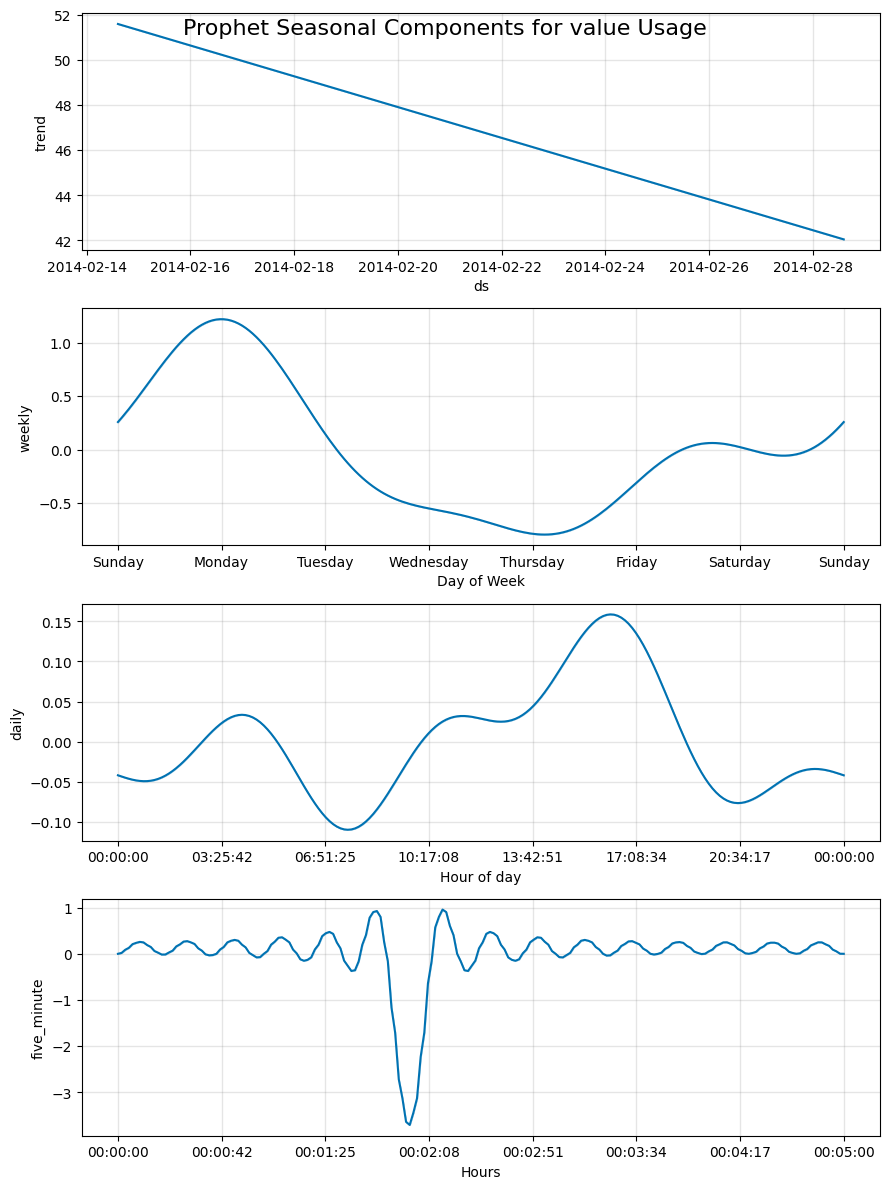

###############CPR = 0.0316###########


08:06:02 - cmdstanpy - INFO - Chain [1] start processing
08:06:03 - cmdstanpy - INFO - Chain [1] done processing


--- Anomaly Detection for: VALUE ---
Number of anomalies found: 3

Anomalous data points:
                      ds       y  yhat_lower  yhat_upper
1218 2014-02-18 19:57:00  55.846   40.422356   48.401687
1271 2014-02-19 00:22:00  62.056   40.246533   48.234298
2970 2014-02-24 21:57:00  68.092   37.193943   45.097964


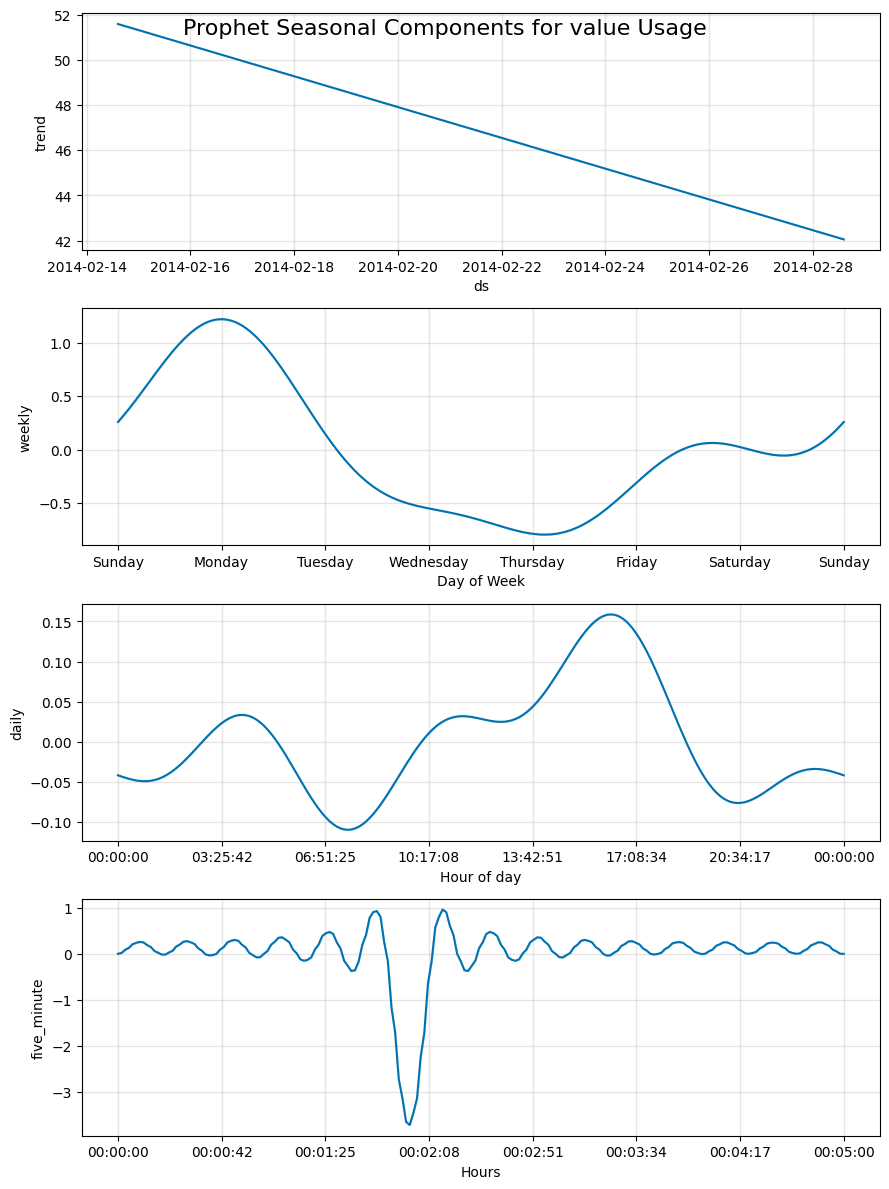

###############CPR = 1.0###########


08:06:07 - cmdstanpy - INFO - Chain [1] start processing
08:06:10 - cmdstanpy - INFO - Chain [1] done processing


--- Anomaly Detection for: VALUE ---
Number of anomalies found: 2

Anomalous data points:
                      ds       y  yhat_lower  yhat_upper
1271 2014-02-19 00:22:00  62.056   41.426509   49.335862
2970 2014-02-24 21:57:00  68.092   36.727094   44.335590


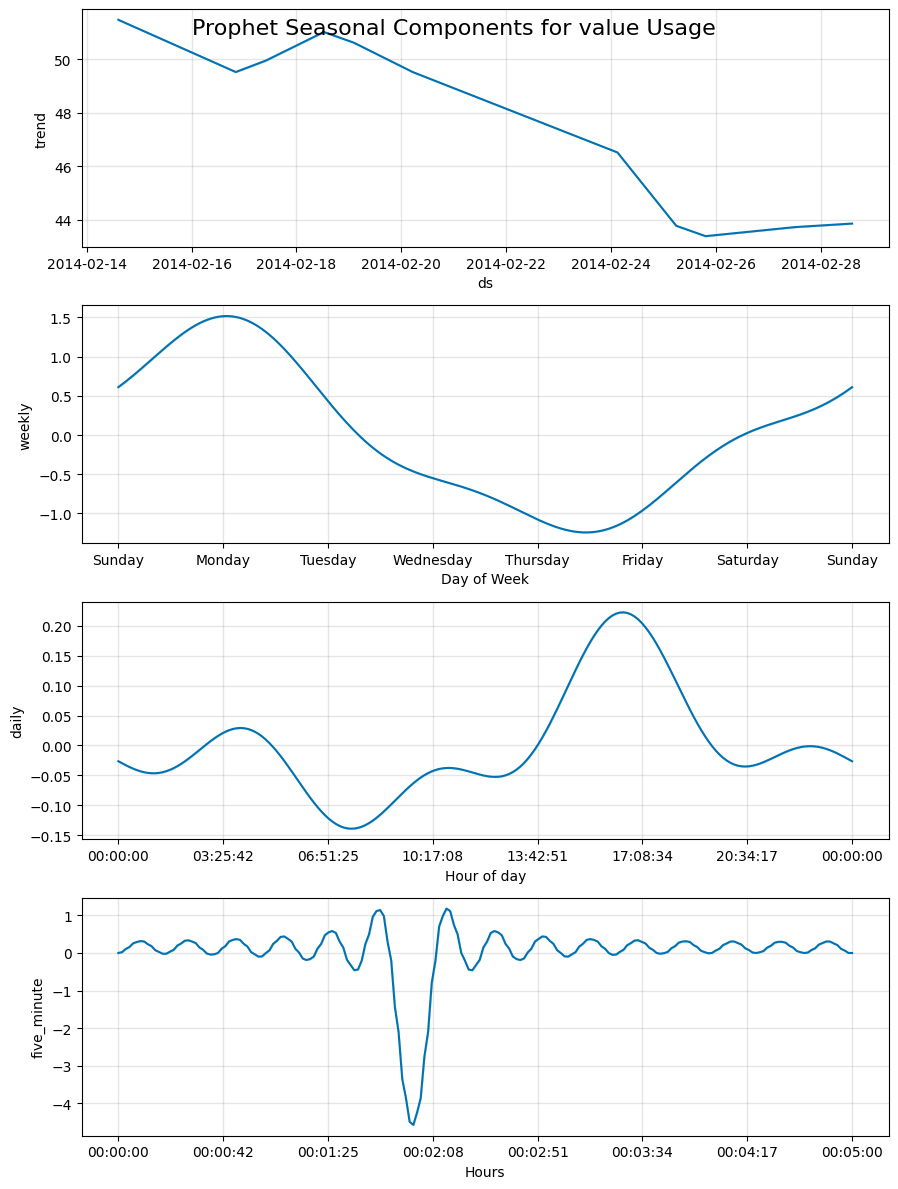

In [19]:
def run_metric_analysis(metric_name):
  # Run the analysis for CPU
  for cpr in np.round(np.logspace(start=-3,stop=0,num=3,base=10),4):
    print(f"###############CPR = {cpr}###########")
    prophet_model, forecast_df, anomalies, forecast = run_prophet_anomaly_detection(data_converted, metric_name, cpr)

    # Check if the model fitting was successful before attempting to plot
    if prophet_model is not None and forecast is not None:
        # Visualize the seasonal components learned by Prophet
        fig = prophet_model.plot_components(forecast)
        fig.suptitle(f'Prophet Seasonal Components for {metric_name} Usage', fontsize=16)
        plt.show()
    else:
        print("Skipping plotting due to errors in model fitting.")
    plot_metric(forecast_df, anomalies, metric_name)

run_metric_analysis('value')